In [1]:
!pip install -q transformers datasets evaluate sentencepiece accelerate google-generativeai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 24.7 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install -q pandas matplotlib seaborn datasets

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_from_disk, DatasetDict
from transformers import (
    AutoTokenizer, 
    AutoModelForSeq2SeqLM, 
    DataCollatorForSeq2Seq, 
    Seq2SeqTrainingArguments, 
    Seq2SeqTrainer
)
import evaluate

# Tắt warning Tokenizer để log sạch đẹp
os.environ["TOKENIZERS_PARALLELISM"] = "false"

2025-11-30 08:22:18.880254: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764490939.157262      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764490939.234756      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
CSV_PATH = "/kaggle/input/phomt-translation-dataset/PhoMT.csv"

print(f"📥 Đang đọc file CSV từ: {CSV_PATH}")

try:
    df = pd.read_csv(CSV_PATH)

    rename_map = {
        "EnglishSentences": "en_text", 
        "VietnameseSentences": "vi_text",
        "en": "en_text",
        "vi": "vi_text"
    }
    df = df.rename(columns=rename_map)
    
    print("✅ Load thành công!")
    print(f"📊 Tổng số dòng: {len(df):,}")
    print(df.head())

except FileNotFoundError:
    print("❌ Vẫn chưa đúng đường dẫn file CSV. Em hãy copy chính xác từ kết quả Bước 1 nhé.")
except Exception as e:
    print(f"❌ Lỗi khác: {e}")

📥 Đang đọc file CSV từ: /kaggle/input/phomt-translation-dataset/PhoMT.csv
✅ Load thành công!
📊 Tổng số dòng: 2,977,999
                                             en_text  \
0                     It begins with a countdown .\n   
1  On August 14th , 1947 , a woman in Bombay goes...   
2  Across India , people hold their breath for th...   
3  And at the stroke of midnight , a squirming in...   
4  These events form the foundation of " Midnight...   

                                             vi_text  
0       Câu chuyện bắt đầu với buổi lễ đếm ngược .\n  
1  Ngày 14 , tháng 8 , năm 1947 , gần nửa đêm , ở...  
2  Cùng lúc , trên khắp đất Ấn , người ta nín thở...  
3  Khi đồng hồ điểm thời khắc nửa đêm , một đứa t...  
4  Những sự kiện này là nền móng tạo nên " Những ...  


In [5]:
def clean_data(df):
    print("\n🧹 Đang làm sạch dữ liệu...")
    initial_len = len(df)
    
    # Xóa dòng Null
    df = df.dropna(subset=['en_text', 'vi_text'])
    
    # Xóa dòng trùng lặp (Duplicate)
    df = df.drop_duplicates(subset=['en_text'])
    
    # Tính độ dài số từ
    df['len_en'] = df['en_text'].astype(str).apply(lambda x: len(x.split()))
    df['len_vi'] = df['vi_text'].astype(str).apply(lambda x: len(x.split()))
    
    # Lọc câu quá ngắn (rác) hoặc quá dài (gây OOM)
    # Giữ lại câu từ 3 đến 150 từ
    df = df[(df['len_en'] >= 3) & (df['len_en'] <= 150)]
    df = df[(df['len_vi'] >= 3) & (df['len_vi'] <= 150)]
    
    print(f"   - Ban đầu: {initial_len:,} dòng")
    print(f"   - Còn lại: {len(df):,} dòng sạch")
    return df

df_clean = clean_data(df)


🧹 Đang làm sạch dữ liệu...
   - Ban đầu: 2,977,999 dòng
   - Còn lại: 2,877,823 dòng sạch


In [6]:
# --- 2. LẤY MẪU 12K (SAMPLING) ---
TOTAL_SAMPLES = 12000
print(f"\n✂️ Đang lấy ngẫu nhiên {TOTAL_SAMPLES:,} mẫu...")

# random_state=42 giúp kết quả luôn cố định (không bị đổi mỗi lần chạy)
if len(df_clean) >= TOTAL_SAMPLES:
    df_12k = df_clean.sample(n=TOTAL_SAMPLES, random_state=42)
else:
    print(f"⚠️ Cảnh báo: Dữ liệu sạch chỉ còn {len(df_clean)} dòng, lấy toàn bộ.")
    df_12k = df_clean.copy()

# Chia tập Train (10k) - Val (1k) - Test (1k)
train_end = 10000
val_end = 11000

df_train = df_12k.iloc[:train_end]        # 0 -> 10,000
df_val = df_12k.iloc[train_end:val_end]   # 10,000 -> 11,000
df_test = df_12k.iloc[val_end:]           # 11,000 -> 12,000

print(f"✅ Đã chia tập dữ liệu:")
print(f"   - Train set: {len(df_train):,} câu")
print(f"   - Valid set: {len(df_val):,} câu")
print(f"   - Test set:  {len(df_test):,} câu")


✂️ Đang lấy ngẫu nhiên 12,000 mẫu...
✅ Đã chia tập dữ liệu:
   - Train set: 10,000 câu
   - Valid set: 1,000 câu
   - Test set:  1,000 câu



📊 Đang vẽ biểu đồ phân phối...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

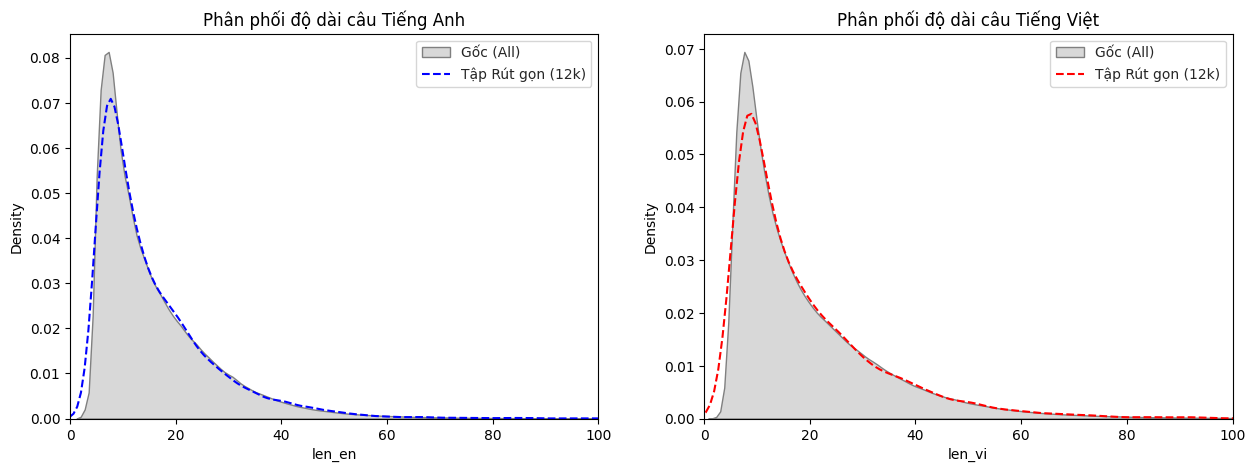

In [7]:
# --- 3. VẼ BIỂU ĐỒ SO SÁNH (VISUALIZATION) ---
# Biểu đồ này dùng để chứng minh trong báo cáo là tập 12k có phân phối chuẩn
print("\n📊 Đang vẽ biểu đồ phân phối...")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("whitegrid")

# Biểu đồ Tiếng Anh
sns.kdeplot(df_clean['len_en'], ax=axes[0], color='grey', fill=True, label='Gốc (All)', alpha=0.3)
sns.kdeplot(df_12k['len_en'], ax=axes[0], color='blue', label='Tập Rút gọn (12k)', linestyle='--')
axes[0].set_title("Phân phối độ dài câu Tiếng Anh")
axes[0].set_xlim(0, 100)
axes[0].legend()

# Biểu đồ Tiếng Việt
sns.kdeplot(df_clean['len_vi'], ax=axes[1], color='grey', fill=True, label='Gốc (All)', alpha=0.3)
sns.kdeplot(df_12k['len_vi'], ax=axes[1], color='red', label='Tập Rút gọn (12k)', linestyle='--')
axes[1].set_title("Phân phối độ dài câu Tiếng Việt")
axes[1].set_xlim(0, 100)
axes[1].legend()

plt.show()


In [8]:
import shutil
from IPython.display import FileLink
from datasets import Dataset, DatasetDict

# Chuyển về định dạng HuggingFace DatasetDict
final_dataset = DatasetDict({
    'train': Dataset.from_pandas(df_train[['en_text', 'vi_text']], preserve_index=False),
    'validation': Dataset.from_pandas(df_val[['en_text', 'vi_text']], preserve_index=False),
    'test': Dataset.from_pandas(df_test[['en_text', 'vi_text']], preserve_index=False)
})

# Lưu ra ổ đĩa
SAVE_PATH = "/kaggle/working/nlp_12k_data"
final_dataset.save_to_disk(SAVE_PATH)

# Nén
print("📦 Đang nén file...")
shutil.make_archive("/kaggle/working/dataset_12k_clean", 'zip', SAVE_PATH)

# Tạo link tải
print("\n👇 Tải file này về máy tính để dùng cho Notebook Train (GPU):")
display(FileLink("dataset_12k_clean.zip"))

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1000 [00:00<?, ? examples/s]

📦 Đang nén file...

👇 Tải file này về máy tính để dùng cho Notebook Train (GPU):


/kaggle/working/dataset_12k_clean.zip

In [9]:
from transformers import AutoTokenizer
from datasets import concatenate_datasets

# --- 1. CẤU HÌNH ---
MODEL_CHECKPOINT = "VietAI/vit5-base"
MAX_LENGTH = 128

datasets = DatasetDict({
    'train': Dataset.from_pandas(df_train[['en_text', 'vi_text']], preserve_index=False),
    'validation': Dataset.from_pandas(df_val[['en_text', 'vi_text']], preserve_index=False),
    'test': Dataset.from_pandas(df_test[['en_text', 'vi_text']], preserve_index=False)
})

# Định nghĩa 2 loại prefix
PREFIX_EN_VI = "dịch Anh sang Việt: "
PREFIX_VI_EN = "dịch Việt sang Anh: "

print(f"⚙️ Đang tải Tokenizer: {MODEL_CHECKPOINT}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

# --- 2. HÀM TOKENIZE THÔNG MINH (2 CHIỀU) ---
def preprocess_bidirectional(examples):
    # --- CHIỀU 1: EN -> VI ---
    inputs_en_vi = [PREFIX_EN_VI + str(ex) for ex in examples["en_text"]]
    targets_en_vi = [str(ex) for ex in examples["vi_text"]]
    
    # --- CHIỀU 2: VI -> EN (Đảo ngược lại) ---
    inputs_vi_en = [PREFIX_VI_EN + str(ex) for ex in examples["vi_text"]]
    targets_vi_en = [str(ex) for ex in examples["en_text"]]
    
    # Gộp cả 2 chiều vào chung 1 list
    # Kết quả sẽ là: [En->Vi sample 1, Vi->En sample 1, En->Vi sample 2, ...]
    all_inputs = inputs_en_vi + inputs_vi_en
    all_targets = targets_en_vi + targets_vi_en
    
    # Tokenize toàn bộ
    model_inputs = tokenizer(
        all_inputs, 
        text_target=all_targets, 
        max_length=MAX_LENGTH, 
        truncation=True
    )
    return model_inputs

# --- 3. THỰC HIỆN ---
# Giả sử em đang có biến 'datasets' chứa 3 tập train/test/val (dạng text thô)
# Lưu ý: Lúc này số lượng mẫu sẽ TĂNG GẤP ĐÔI

print("🔄 Đang Tokenize dữ liệu 2 chiều (Bidirectional)...")

# Xóa các cột cũ để tránh lỗi (vì giờ input/target đã trộn lẫn lộn)
column_names = datasets["train"].column_names

tokenized_datasets = datasets.map(
    preprocess_bidirectional,
    batched=True,
    remove_columns=column_names,
    desc="Running bidirectional tokenizer"
)

# Shuffle (Xáo trộn) lại lần nữa để model không học theo cụm
# (Tránh trường hợp model học hết En-Vi rồi mới học Vi-En)
tokenized_datasets = tokenized_datasets.shuffle(seed=42)

# --- 4. KIỂM TRA KẾT QUẢ ---
print("\n✅ Tokenize 2 chiều hoàn tất!")
print(tokenized_datasets)

print("\n🔍 Soi thử dữ liệu (Em sẽ thấy lúc thì input là tiếng Anh, lúc là tiếng Việt):")
for i in range(3):
    sample = tokenized_datasets['train'][i]
    print(f"Sample {i}:")
    print(f" - Input: {tokenizer.decode(sample['input_ids'], skip_special_tokens=True)}")
    print(f" - Label: {tokenizer.decode(sample['labels'], skip_special_tokens=True)}")
    print("-" * 30)

# --- 5. LƯU VÀ NÉN ---
SAVE_PATH = "/kaggle/working/tokenized_12k_data"
ZIP_NAME = "dataset_12k_tokenized"

print(f"\n💾 Đang lưu dataset đã xử lý vào {SAVE_PATH}...")
tokenized_datasets.save_to_disk(SAVE_PATH)

print(f"📦 Đang nén thành {ZIP_NAME}.zip ...")
shutil.make_archive(f"/kaggle/working/{ZIP_NAME}", 'zip', SAVE_PATH)

# --- 6. TẠO LINK TẢI ---
print("\n🎉 XONG TOÀN BỘ GIAI ĐOẠN 1!")
print("👇 Bấm vào link dưới đây để tải dataset 'ăn liền' về máy tính:")
display(FileLink(f"{ZIP_NAME}.zip"))

⚙️ Đang tải Tokenizer: VietAI/vit5-base...


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/820k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

🔄 Đang Tokenize dữ liệu 2 chiều (Bidirectional)...


Running bidirectional tokenizer:   0%|          | 0/10000 [00:00<?, ? examples/s]

Running bidirectional tokenizer:   0%|          | 0/1000 [00:00<?, ? examples/s]

Running bidirectional tokenizer:   0%|          | 0/1000 [00:00<?, ? examples/s]


✅ Tokenize 2 chiều hoàn tất!
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

🔍 Soi thử dữ liệu (Em sẽ thấy lúc thì input là tiếng Anh, lúc là tiếng Việt):
Sample 0:
 - Input: dịch Anh sang Việt: What do you mean , " data " ? 
 - Label: Ý là sao , " dữ liệu " ? 
------------------------------
Sample 1:
 - Input: dịch Anh sang Việt: Always consider what you can learn from whatever situation you encounter . 
 - Label: Phải luôn cân nhắc những điều bạn học được từ tình huống trong cuộc sống . 
------------------------------
Sample 2:
 - Input: dịch Việt sang Anh: Chờ nước ép khô rồi rửa sạch . 
 - Label: Let it dry , the wash it off . 
------------------------------

💾 Đang lưu datas

Saving the dataset (0/1 shards):   0%|          | 0/20000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

📦 Đang nén thành dataset_12k_tokenized.zip ...

🎉 XONG TOÀN BỘ GIAI ĐOẠN 1!
👇 Bấm vào link dưới đây để tải dataset 'ăn liền' về máy tính:


/kaggle/working/dataset_12k_tokenized.zip